# MMSegmentation Tutorial
Welcome to MMSegmentation! 

Tutorial modified from : https://github.com/open-mmlab/mmsegmentation/blob/main/demo/MMSegmentation_Tutorial.ipynb

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [1]:
# download and unzip
#!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
#!tar xf stanford_background.tar.gz

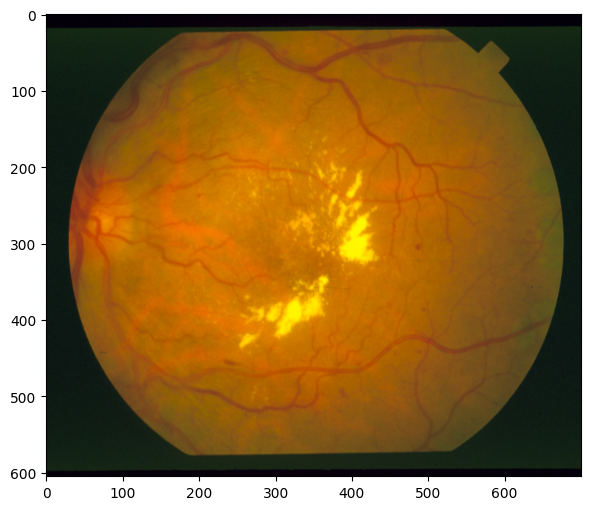

In [15]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt


img = mmcv.imread('/data/STARE/images/training/im0001.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [24]:
# define dataset root and directory for images and annotations
data_root = '/data/STARE'
img_dir = 'images'
ann_dir = 'annotations'
#define class and palette for better visualization
classes = ('background', 'vessel')
PALETTE = [[120, 120, 120], [6, 230, 230]]


In [25]:
import os.path as osp
import numpy as np
from PIL import Image

# convert dataset annotation to semantic segmentation map and save as .png
for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
                                                         '.png')))

IndexError: tuple index out of range

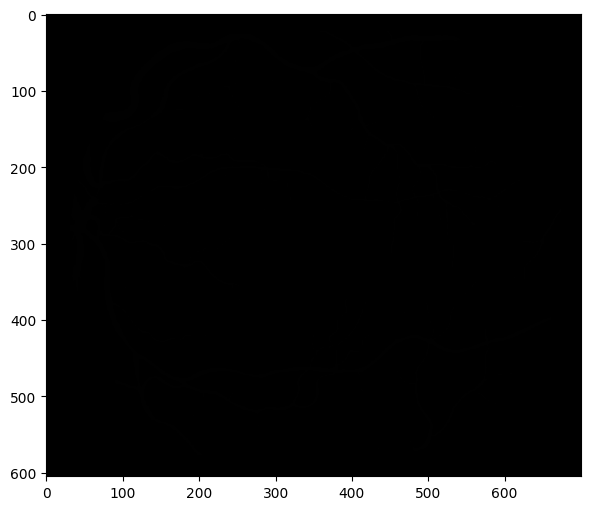

In [27]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('/data/STARE/annotations/training/im0001.ah.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(6)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [6]:
# split train/val set randomly
split_dir = 'splits'

#create 'splits' directory in data directory if it doesn't already exist
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))

#get a list of all of the file names with .png at the end
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [7]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)
    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [8]:
# Download config and checkpoint files
#!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .

In [9]:
from mmengine import Config
cfg = Config.fromfile('../../submodules/lib-avstack-core/third_party/mmsegmentation/configs/unet/unet-s5-d16_fcn_4xb4-160k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 1024)),
    pretrained=None,
    backbone=dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='SyncBN', requires_grad

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [10]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = '/models/mmseg/checkpoints/Cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/models/mmseg/work_dirs/tutorial'

cfg.train_cfg.max_iters = 200
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(256, 256)),
    pretrained=None,
    backbone=dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='BN', requires_grad=True),
 

### Train and Evaluation

In [11]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

07/26 17:27:37 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.10 (default, May 26 2023, 14:05:08) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA T1000 8GB
    CUDA_HOME: None
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.10.0+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_7

/home/amir/Documents/radar-dev/submodules/lib-avstack-core/third_party/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/amir/Documents/radar-dev/submodules/lib-avstack-core/third_party/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


07/26 17:27:40 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
07/26 17:27:40 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/amir/Documents/radar-dev/submodules/lib-avstack-core/third_party/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [12]:
# start training
runner.train()

07/26 17:27:40 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
Loads checkpoint by local backend from path: /models/mmseg/checkpoints/Cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 64, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.convs.0.conv.

RuntimeError: CUDA out of memory. Tried to allocate 4.19 GiB (GPU 0; 7.78 GiB total capacity; 1.04 GiB already allocated; 4.20 GiB free; 1.99 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Inference with trained model

/home/amir/Documents/radar-dev/submodules/lib-avstack-core/third_party/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/amir/Documents/radar-dev/submodules/lib-avstack-core/third_party/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /models/mmseg/work_dirs/tutorial/iter_200.pth
07/25 16:53:20 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


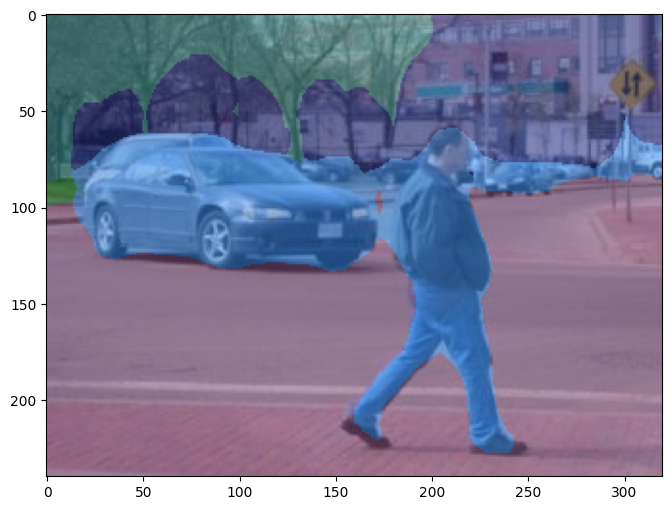

In [ ]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = '/models/mmseg/work_dirs/tutorial/iter_200.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('/data/iccv09Data/images/6000124.jpg')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))
